In [0]:
import numpy as np
import pandas as pd 
import re
from keras.preprocessing.text import Tokenizer 
from keras.preprocessing.sequence import pad_sequences
from nltk.corpus import stopwords
from keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed
from tensorflow.keras.layers import Attention
from keras.models import Model
from keras.callbacks import EarlyStopping
import warnings
import matplotlib.pyplot as plt
from keras.preprocessing.text import Tokenizer 
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

In [0]:
BATCH_SIZE=64
EPOCHS=50
latent_dim = 50
embedding_dim=450

In [238]:
df = pd.read_csv('./data0.csv')
df.head(1)

,Unnamed: 0,file,text,summary
0,0,0002c17436637c4fe1837c935c04de47adb18e9a.story,Los Angeles A medical doctor Vancouver British...,NEW A Canadian doctor says she was part of a t...


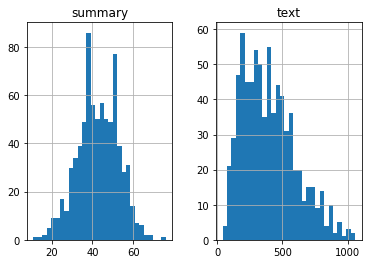

In [239]:
text_word_count = []
summary_word_count = []

# populate the lists with sentence lengths
for i in df['text']:
      text_word_count.append(len(i.split(' ')))

for i in df['summary']:
      summary_word_count.append(len(i.split(' ')))

length_df = pd.DataFrame({'text':text_word_count, 'summary':summary_word_count})

length_df.hist(bins = 30)
plt.show()

In [240]:
cnt=0
for i in df['summary']:
    if(len(i.split())<=60):
        cnt=cnt+1
print(cnt/len(df['summary']))

0.9777195281782438


In [241]:
cnt=0
for i in df['text']:
    if(len(i.split())<=600):
        cnt=cnt+1
print(cnt/len(df['text']))

0.8401048492791612


In [0]:
max_text_len=600
max_summary_len=60

In [243]:
x_tr,x_val,y_tr,y_val=train_test_split(np.array(df['text']),np.array(df['summary']),test_size=0.2,random_state=0,shuffle=True)
print(x_tr.shape)
print(x_val.shape)
print(y_tr.shape)
print(y_val.shape)

(610,)
(153,)
(610,)
(153,)


In [0]:
#prepare a tokenizer for reviews on training data
x_tokenizer = Tokenizer() 
x_tokenizer.fit_on_texts(list(x_tr))

In [245]:
thresh=3

cnt=0
tot_cnt=0
freq=0
tot_freq=0

for key,value in x_tokenizer.word_counts.items():
    tot_cnt=tot_cnt+1
    tot_freq=tot_freq+value
    if(value<thresh):
        cnt=cnt+1
        freq=freq+value
    
print("% of rare words in vocabulary:",(cnt/tot_cnt)*100)
print("Total Coverage of rare words:",(freq/tot_freq)*100)

% of rare words in vocabulary: 59.857281594392596
Total Coverage of rare words: 7.242643456677227


In [246]:
#prepare a tokenizer for reviews on training data
x_tokenizer = Tokenizer(num_words=tot_cnt) 
x_tokenizer.fit_on_texts(list(x_tr))

#convert text sequences into integer sequences
x_tr_seq    =   x_tokenizer.texts_to_sequences(x_tr) 
x_val_seq   =   x_tokenizer.texts_to_sequences(x_val)

#padding zero upto maximum length
x_tr    =   pad_sequences(x_tr_seq,  maxlen=max_text_len, padding='post')
x_val   =   pad_sequences(x_val_seq, maxlen=max_text_len, padding='post')

#size of vocabulary ( +1 for padding token)
x_voc   =  x_tokenizer.num_words + 1
print(x_voc)

23684


In [0]:
#prepare a tokenizer for reviews on training data
y_tokenizer = Tokenizer()   
y_tokenizer.fit_on_texts(list(y_tr))

In [248]:
thresh=2

cnt=0
tot_cnt=0
freq=0
tot_freq=0

for key,value in y_tokenizer.word_counts.items():
    tot_cnt=tot_cnt+1
    tot_freq=tot_freq+value
    if(value<thresh):
        cnt=cnt+1
        freq=freq+value
    
print("% of rare words in vocabulary:",(cnt/tot_cnt)*100)
print("Total Coverage of rare words:",(freq/tot_freq)*100)

% of rare words in vocabulary: 57.39552132363429
Total Coverage of rare words: 15.411129409061314


In [249]:
#prepare a tokenizer for reviews on training data
y_tokenizer = Tokenizer(num_words=tot_cnt) 
y_tokenizer.fit_on_texts(list(y_tr))

#convert text sequences into integer sequences
y_tr_seq    =   y_tokenizer.texts_to_sequences(y_tr) 
y_val_seq   =   y_tokenizer.texts_to_sequences(y_val) 

#padding zero upto maximum length
y_tr    =   pad_sequences(y_tr_seq, maxlen=max_summary_len, padding='post')
y_val   =   pad_sequences(y_val_seq, maxlen=max_summary_len, padding='post')

#size of vocabulary
y_voc  =   y_tokenizer.num_words +1
print(y_voc)

7012


In [250]:
# Encoder
encoder_inputs = Input(shape=(None,))
#embedding layer
enc_emb =  Embedding(x_voc, embedding_dim,trainable=True)(encoder_inputs)
#encoder lstm 1
encoder_lstm1 = LSTM(latent_dim,return_sequences=True,return_state=True)
encoder_outputs, state_h, state_c = encoder_lstm1(enc_emb)

# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None,))

#embedding layer
dec_emb_layer = Embedding(y_voc, embedding_dim,trainable=True)
dec_emb = dec_emb_layer(decoder_inputs)

decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True,dropout=0.4,recurrent_dropout=0.2)
decoder_outputs,decoder_fwd_state, decoder_back_state = decoder_lstm(dec_emb,initial_state=[state_h, state_c])
                                                          
#dense layer
decoder_dense = Dense(y_voc, activation='softmax')
# decoder_dense = Dense(y_voc, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

# Define the model 
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

model.summary()

Model: "model_39"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_71 (InputLayer)           (None, None)         0                                            
__________________________________________________________________________________________________
input_72 (InputLayer)           (None, None)         0                                            
__________________________________________________________________________________________________
embedding_39 (Embedding)        (None, None, 450)    10657800    input_71[0][0]                   
__________________________________________________________________________________________________
embedding_40 (Embedding)        (None, None, 450)    3155400     input_72[0][0]                   
___________________________________________________________________________________________

In [0]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')

In [0]:
# es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=2)

In [253]:
history=model.fit([x_tr,y_tr[:,:-1]], y_tr.reshape(y_tr.shape[0],y_tr.shape[1], 1)[:,1:] ,epochs=EPOCHS, batch_size=BATCH_SIZE, validation_data=([x_val,y_val[:,:-1]], y_val.reshape(y_val.shape[0],y_val.shape[1], 1)[:,1:]))

Train on 610 samples, validate on 153 samples
Epoch 1/50
610/610 [==============================] - 21s 35ms/step - loss: 8.6195 - val_loss: 7.7394
Epoch 2/50
610/610 [==============================] - 14s 23ms/step - loss: 7.6354 - val_loss: 6.7307
Epoch 3/50
610/610 [==============================] - 15s 24ms/step - loss: 7.0131 - val_loss: 6.1771
Epoch 4/50
610/610 [==============================] - 14s 23ms/step - loss: 6.6564 - val_loss: 5.7967
Epoch 5/50
610/610 [==============================] - 14s 23ms/step - loss: 6.4080 - val_loss: 5.4946
Epoch 6/50
610/610 [==============================] - 14s 23ms/step - loss: 6.2168 - val_loss: 5.2405
Epoch 7/50
610/610 [==============================] - 14s 23ms/step - loss: 6.0605 - val_loss: 5.0248
Epoch 8/50
610/610 [==============================] - 14s 23ms/step - loss: 5.9259 - val_loss: 4.8458
Epoch 9/50
610/610 [==============================] - 15s 24ms/step - loss: 5.8031 - val_loss: 4.6959
Epoch 10/50
610/610 [===============

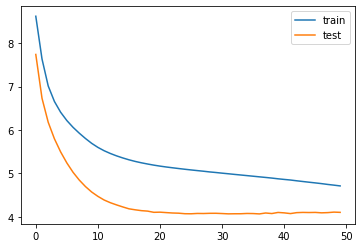

In [254]:
from matplotlib import pyplot
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [0]:
reverse_target_word_index=y_tokenizer.index_word
reverse_source_word_index=x_tokenizer.index_word
target_word_index=y_tokenizer.word_index

In [0]:
# Encode the input sequence to get the feature vector
encoder_model = Model(inputs=encoder_inputs,outputs=[encoder_outputs, state_h, state_c])

# Decoder setup
# Below tensors will hold the states of the previous time step
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_hidden_state_input = Input(shape=(max_text_len,latent_dim))
decoder_state_inputs = [decoder_state_input_h, decoder_state_input_c]

# Get the embeddings of the decoder sequence
dec_emb2= dec_emb_layer(decoder_inputs) 
# To predict the next word in the sequence, set the initial states to the states from the previous time step
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=decoder_state_inputs)

# A dense softmax layer to generate prob dist. over the target vocabulary
decoder_outputs2 = decoder_dense(decoder_outputs2) 

# Final decoder model
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

In [257]:
decoder_model.summary()

Model: "model_41"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_72 (InputLayer)           (None, None)         0                                            
__________________________________________________________________________________________________
embedding_40 (Embedding)        (None, None, 450)    3155400     input_72[0][0]                   
__________________________________________________________________________________________________
input_73 (InputLayer)           (None, 50)           0                                            
__________________________________________________________________________________________________
input_74 (InputLayer)           (None, 50)           0                                            
___________________________________________________________________________________________

In [0]:
def seq2summary(input_seq):
    newString=''
    for i in input_seq:
        if(i!=0):
            newString=newString+reverse_target_word_index[i]+' '
    return newString

def seq2text(input_seq):
    newString=''
    for i in input_seq:
        if(i!=0):
            newString=newString+reverse_source_word_index[i]+' '
    return newString

In [0]:
def decode_sequence(input_seq): 
    # Encode the input as state vectors.
    e_out, e_h, e_c = encoder_model.predict(input_seq)
    target_seq = np.zeros((1,1))
    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
      output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c]) 
      sampled_token_index = np.argmax(output_tokens[0, -1, :])
      print(sampled_token_index)
      if (sampled_token_index != 0 ):
        sampled_token = reverse_target_word_index[sampled_token_index]
        decoded_sentence += ' '+sampled_token
      else :
        stop_condition = True
      if (len(decoded_sentence.split()) >= (max_summary_len-1)):
              stop_condition = True
       # Update the target sequence (of length 1).
      target_seq = np.zeros((1,1))
      target_seq[0, 0] = sampled_token_index

      # Update internal states
      e_h, e_c = h, c
    return decoded_sentence

In [263]:
for i in range(0,1):
    print("Article:",seq2text(x_tr[i]))
    print("Original summary:",seq2summary(y_tr[i]))
    print("Generated summary:",decode_sequence(x_tr[i].reshape(1,max_text_len)))
    print("\n")

Article: proceedings end day defense attorney mark omara object earlier call prosecutor argue necessary explain zimmermans remark burglar get away the martin family sat watch proceeding behind state attorney angela corey before witness testimony begin judge debra nelson deny defense request martins father tracy martin leave courtroom tracy martin potential witness potential witness force sit outside courtroom keep testimony taint witness but nextofkin victim allow remain court even theyre expect testify omara also accuse tracy martin use obscenity toward friend zimmermans hold door hearing two week ago the friend timothy tucholski testify hadnt want make issue i wasnt planning come i dont want sit say but nelson deny request martin remain court zimmermans parent cover rule regard potential witness sit outside benjamin crump lawyer martins parent at one point martins father begin cry guy detailed officer try save son life zimmerman mostly star straight ahead without sign emotion followi